# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [127]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [128]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [130]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [131]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 5.504314 (||params||=4.317492, ||grad||=7.676059, ||E[dr/dw]||=6.588705)
INFO:root:Occupancy measure error@iter  100: 0.045184 (||params||=5.044746, ||grad||=0.059398, ||E[dr/dw]||=6.971343)
INFO:root:Occupancy measure error@iter  200: 0.012208 (||params||=4.912653, ||grad||=0.016860, ||E[dr/dw]||=6.940515)
INFO:root:Occupancy measure error@iter  300: 0.005907 (||params||=4.908501, ||grad||=0.007435, ||E[dr/dw]||=6.939543)
INFO:root:Occupancy measure error@iter  400: 0.002958 (||params||=4.911251, ||grad||=0.003578, ||E[dr/dw]||=6.940352)
INFO:root:Occupancy measure error@iter  500: 0.001553 (||params||=4.912214, ||grad||=0.001851, ||E[dr/dw]||=6.940836)


In [132]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8535e+00 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 1.2728e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]

Recovered state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8535e+00 4.7743e-02 0.0000e+00]
 [0.0000e+00 1.0982e+00 6.4709e-04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [133]:
irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
rng = jrandom.PRNGKey(42)
irl_bias_params, rng = irl_feedback_model.init_bias_params(rng)
irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
# we'll do IRL based on 10 trajectories
irl_dataset = irl_expert.interact(10)

In [134]:
print('Log likelihood (IRL):', float(irl_feedback_model.log_likelihood(irl_dataset, rmodel, irl_bias_params)))
print('Gradient w.r.t. reward params (IRL):\n', np.asarray(irl_feedback_model.log_likelihood_grad_rew(irl_dataset, rmodel, irl_bias_params)))
print('Gradient w.r.t. bias params (IRL):\n', irl_feedback_model.log_likelihood_grad_bias(irl_dataset, rmodel, irl_bias_params))

Log likelihood (IRL): -13.663637161254883
Gradient w.r.t. reward params (IRL):
 [ 0.      0.      0.      0.      0.      0.196  -0.0096  0.      0.     -0.0523 -0.0397  0.
  0.      0.      0.      0.    ]
Gradient w.r.t. bias params (IRL):
 [ 0.      0.      0.      0.      0.     -0.1026  0.0207  0.      0.     -0.0879 -0.0184  0.
  0.      0.      0.      0.    ]


## Another example with the paired comparison learner

In [135]:
pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
pc_bias_params, rng = pc_feedback_model.init_bias_params(rng)
pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

# generate some random trajectories & compare a random subset of them
def generate_comparison_dataset(pc_ntraj):
    pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
    to_compare_first = np.arange(len(pc_trajectories['states']))
    comparisons = []
    for first_idx in range(pc_ntraj):
        second_idx = np.random.randint(pc_ntraj - 1)
        if second_idx >= first_idx:
            second_idx += 1
        traj1_is_better = pc_expert.interact(
            dict(states=pc_trajectories['states'][first_idx]),
            dict(states=pc_trajectories['states'][second_idx]))
        if traj1_is_better:
            # the better trajectory comes before the worse one
            comparisons.append((first_idx, second_idx))
        else:
            comparisons.append((second_idx, first_idx))
    return {
        'trajectories': pc_trajectories,
        'comparisons': np.asarray(comparisons),
    }

comparison_dataset = generate_comparison_dataset(10)

In [136]:
print('Log likelihood (PC):', float(pc_feedback_model.log_likelihood(comparison_dataset, rmodel, pc_bias_params)))
print('Gradient w.r.t. reward params (PC):\n', np.asarray(pc_feedback_model.log_likelihood_grad_rew(comparison_dataset, rmodel, pc_bias_params)))
print('Gradient w.r.t. bias params (PC):\n', pc_feedback_model.log_likelihood_grad_bias(comparison_dataset, rmodel, pc_bias_params))

Log likelihood (PC): -1.51496160030365
Gradient w.r.t. reward params (PC):
 [ 0.      0.      0.      0.      0.      0.6405  0.4841  0.      0.     -0.409  -0.7157  0.
  0.      0.      0.      0.    ]
Gradient w.r.t. bias params (PC):
 -2.5283113


In [137]:
# ALRIGHT, HERE IS WHERE I WILL DEBUG THE TOPK FEEDBACK LEARNER
# ABLATIONS: COULD WE DO BETTER IF ALL OUR TRAJECTORIES ARE GOOD? 
# OR IS IT NECESSARY TO HAVE BAD TRAJECTORIES? 

In [367]:
import pref_bootstrap.feedback_learner_topk as fbl_topk

rmodel = r_models.LinearRewardModel(env.obs_dim)
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.6, K=.05, seed=42)

In [368]:
# def genereate_top_K_dataset(n_traj): 

n_traj = 1000
traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
labels= top_K_expert.interact(traj)
print('CUTOFF', top_K_expert.cutoff)

[ 0.  0.  3.  0. 12.  6. 18. 15.  0.  0.  3.  6.  6.  0.  0.  0.  0. 12.  3.  0.  3.  6.  0. 15.
  0. 15.  0. 18. 21.  6.  3.  9. 24.  9.  3. 12.  0. 15. 21.  6. 12.  3.  0.  0.  6. 21.  6.  6.
 12.  0.  6.  9. 12.  0.  9.  9. 15.  0.  0.  0.  3.  0.  3.  0.  6.  9.  3.  0.  3.  3.  3.  6.
  0.  3.  3.  9. 24.  6.  0.  3.  3.  3.  0.  6.  9. 18. 12.  6.  3. 15.  6.  0.  6.  6.  0. 15.
  0.  6. 15.  0.  6.  6.  9.  6.  9.  0.  0. 18. 15.  3.  9.  6.  0.  0.  6. 18.  3.  6.  3.  9.
  3.  6.  0.  0.  0.  0.  3.  3. 15. 12.  6.  0.  9.  0.  3.  9.  9.  0.  9. 18. 12.  9.  0.  0.
  0.  0.  3.  0.  3.  3.  6.  9.  0.  0. 18.  9. 21. 15.  9.  6. 15.  0. 12. 15.  9. 12.  0.  3.
  6.  3.  9.  3.  0.  0.  6.  6. 18.  6.  6.  0.  6.  0.  9.  9. 15.  0.  0.  6.  9. 12. 18.  3.
  6. 21.  0.  0. 12. 12. 12.  6.  6.  0.  3.  0.  0.  0. 12.  3.  0. 12.  3.  9. 15.  6.  0.  0.
  9. 12.  3.  3. 12.  9. 12.  6.  0.  3. 15.  9.  0.  9.  3.  9.  3. 18.  3.  0.  3. 12.  6.  6.
 18. 12.  3. 12.  3.  0.  9.  

In [399]:
params = {}

from jax import random as jrnd
import jax.numpy as jnp
from jax import grad, value_and_grad
key = jrnd.PRNGKey(0)
key, wkey = jrnd.split(key, 2)
params['reward_est'] = jrnd.normal(wkey, (env.n_states,))
params['bias'] = 10*jnp.ones((1,))
params['temperature'] = .5*jnp.ones((1, ))
lr = 1e-4
steps = 10000
loss_prev = float('Inf')
delta = 100

step = 0
while(np.abs(delta) > .0001 and step<steps):
    loss, gradients = (value_and_grad(top_K_feedback_model.loss)(params, traj['states'], labels))
    print('step %d loss %.3f' %(step, loss))
    if step > 0: 
        delta = loss-loss_prev
        print('delta', delta)
   
    for k in params.keys(): 
        params[k] -= lr*gradients[k]
        
    loss_prev = loss
    step +=1


(1000, 9)
step 0 loss 5.962
(1000, 9)
step 1 loss 5.947
delta -0.014680386
(1000, 9)
step 2 loss 5.933
delta -0.014676571
(1000, 9)
step 3 loss 5.918
delta -0.014670372
(1000, 9)
step 4 loss 5.903
delta -0.014661789
(1000, 9)
step 5 loss 5.889
delta -0.014658928
(1000, 9)
step 6 loss 5.874
delta -0.014652252
(1000, 9)
step 7 loss 5.859
delta -0.014641285
(1000, 9)
step 8 loss 5.845
delta -0.014639378
(1000, 9)
step 9 loss 5.830
delta -0.014634132
(1000, 9)
step 10 loss 5.816
delta -0.014625549
(1000, 9)
step 11 loss 5.801
delta -0.014622688
(1000, 9)
step 12 loss 5.786
delta -0.014611721
(1000, 9)
step 13 loss 5.772
delta -0.014611721
(1000, 9)
step 14 loss 5.757
delta -0.014601231
(1000, 9)
step 15 loss 5.742
delta -0.014595985
(1000, 9)
step 16 loss 5.728
delta -0.01458931
(1000, 9)
step 17 loss 5.713
delta -0.014585495
(1000, 9)
step 18 loss 5.699
delta -0.014575481
(1000, 9)
step 19 loss 5.684
delta -0.014574051
(1000, 9)
step 20 loss 5.670
delta -0.014564514
(1000, 9)
step 21 loss

In [400]:
traj.keys()

dict_keys(['obs', 'states', 'acts'])

In [401]:
np.array(params['reward_est'])

array([ 0.2082, -1.058 , -0.2937, -0.4412,  0.2367, -0.0175, -0.9893,  1.156 , -0.5381, -0.4527,
        0.2703, -1.4129,  1.8543,  0.2276,  0.4975, -2.0897], dtype=float32)

Text(0.5,1,'Estimated Reward Function')

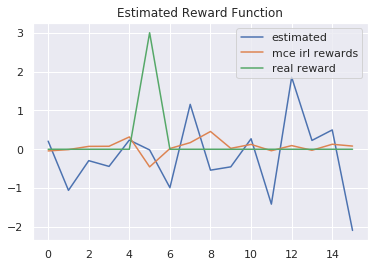

In [402]:
plt.plot(params['reward_est'], label='estimated')
plt.plot(rew_params, label='mce irl rewards')
plt.plot(env.reward_matrix, label='real reward')
plt.legend()
plt.title('Estimated Reward Function')

In [408]:
_, topk_om = mce_irl.mce_occupancy_measures(env, R=params['reward_est'])

In [409]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8535e+00 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 1.2728e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


In [410]:
print('Inferred w. Top K')
print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))

Inferred w. Top K
[[0.     0.     0.     0.    ]
 [0.     1.1558 0.3323 0.    ]
 [0.     2.5824 3.9295 0.    ]
 [0.     0.     0.     0.    ]]


In [411]:
print('Optimal state visitation frequencies for each grid cell:')
print(env.reward_matrix.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [412]:
params

{'reward_est': DeviceArray([ 0.2082, -1.058 , -0.2937, -0.4412,  0.2367, -0.0175, -0.9893,  1.156 , -0.5381,
              -0.4527,  0.2703, -1.4129,  1.8543,  0.2276,  0.4975, -2.0897], dtype=float32),
 'bias': DeviceArray([9.9902], dtype=float32),
 'temperature': DeviceArray([-0.0633], dtype=float32)}